In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
import warnings
warnings.filterwarnings('ignore')

# Dataset description

Source: https://www.kaggle.com/jsphyg/weather-dataset-rattle-package


This dataset contains about 10 years of daily weather observations from numerous Australian weather stations.

The target RainTomorrow means: Did it rain the next day? Yes or No.


1. Date The date of observation
2. Location The common name of the location of the weather station
3. MinTemp The minimum temperature in degrees celsius
4. MaxTemp The maximum temperature in degrees celsius
5. Rainfall The amount of rainfall recorded for the day in mm
6. Evaporation The so-called Class A pan evaporation (mm) in the 24 hours to 9am
7. Sunshine The number of hours of bright sunshine in the day.
8. WindGustDirThe direction of the strongest wind gust in the 24 hours to midnight
9. WindGustSpeedThe speed (km/h) of the strongest wind gust in the 24 hours to midnight
10. WindDir9amDirection of the wind at 9am
11. WindDir3pmDirection of the wind at 3pm
12. WindSpeed9amWind speed (km/hr) averaged over 10 minutes prior to 9am
13. WindSpeed3pmWind speed (km/hr) averaged over 10 minutes prior to 3pm
14. Humidity9amHumidity (percent) at 9am
15. Humidity3pmHumidity (percent) at 3pm
16. Pressure9amAtmospheric pressure (hpa) reduced to mean sea level at 9am
17. Pressure3pmAtmospheric pressure (hpa) reduced to mean sea level at 3pm
18. Cloud9amFraction of sky obscured by cloud at 9am. This is measured in "oktas", which are a unit of eigths. It records how many eigths of the sky are obscured by cloud. A 0 measure indicates completely clear sky whilst an 8 indicates that it is completely overcast.
19. Cloud3pmFraction of sky obscured by cloud (in "oktas": eighths) at 3pm. See Cload9am for a description of the values
20. Temp9amTemperature (degrees C) at 9am
21. Temp3pmTemperature (degrees C) at 3pm
22. RainTodayBoolean: 1 if precipitation (mm) in the 24 hours to 9am exceeds 1mm, otherwise 0
23. RainTomorrow The target variable. Did it rain tomorrow?

In [3]:
data = pd.read_csv('weatherAUS.csv')

In [4]:
# убираем ненужные признаки

data.dropna(inplace=True)
data.drop(['RISK_MM', 'Date'], 1,inplace=True)
data.reset_index(inplace=True, drop=True)
data.shape

(56420, 22)

In [5]:
data.head()

,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,Cobar,17.9,35.2,0.0,12.0,12.3,SSW,48.0,ENE,SW,...,20.0,13.0,1006.3,1004.4,2.0,5.0,26.6,33.4,No,No
1,Cobar,18.4,28.9,0.0,14.8,13.0,S,37.0,SSE,SSE,...,30.0,8.0,1012.9,1012.1,1.0,1.0,20.3,27.0,No,No
2,Cobar,19.4,37.6,0.0,10.8,10.6,NNE,46.0,NNE,NNW,...,42.0,22.0,1012.3,1009.2,1.0,6.0,28.7,34.9,No,No
3,Cobar,21.9,38.4,0.0,11.4,12.2,WNW,31.0,WNW,WSW,...,37.0,22.0,1012.7,1009.1,1.0,5.0,29.1,35.6,No,No
4,Cobar,24.2,41.0,0.0,11.2,8.4,WNW,35.0,NW,WNW,...,19.0,15.0,1010.7,1007.4,1.0,6.0,33.6,37.6,No,No


# Feature exploring

In [6]:
data.columns

Index(['Location', 'MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine',
       'WindGustDir', 'WindGustSpeed', 'WindDir9am', 'WindDir3pm',
       'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm',
       'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am',
       'Temp3pm', 'RainToday', 'RainTomorrow'],
      dtype='object')

In [7]:
target = 'RainTomorrow'

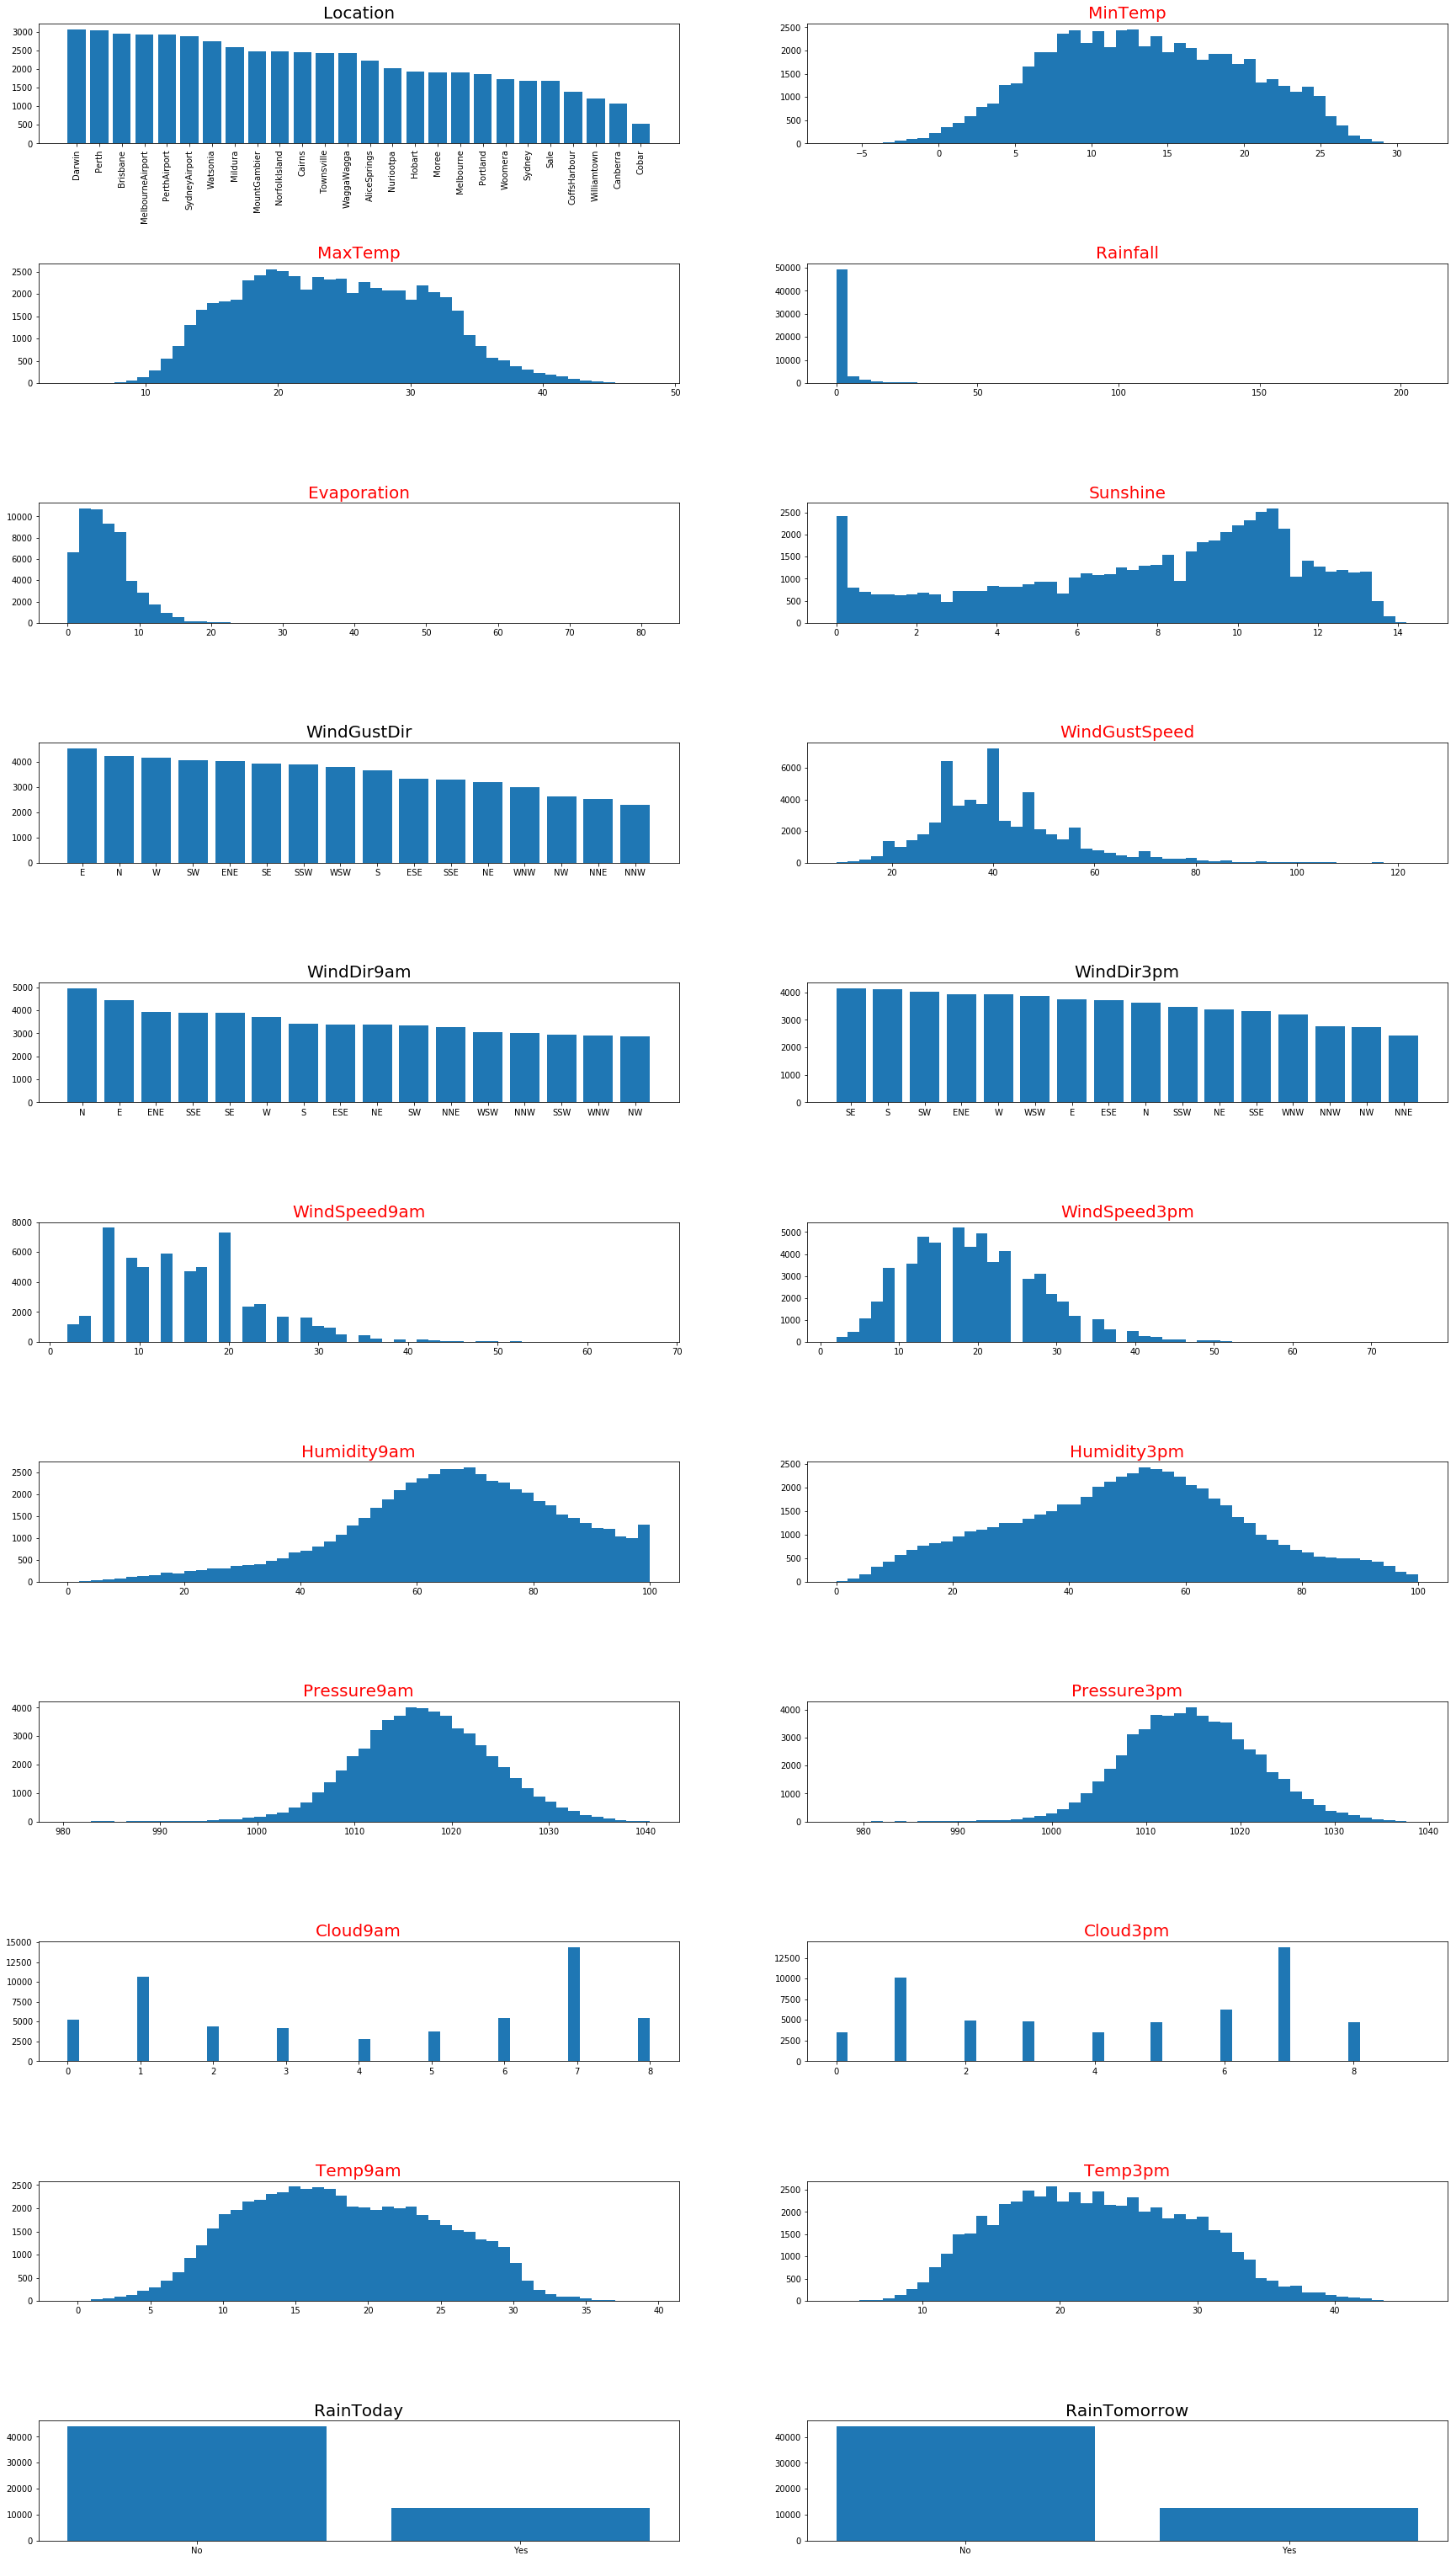

In [8]:
plt.figure(figsize=(30,55))

for i, column in enumerate(data.columns, 1):
    
    if data[column].dtypes==np.float64:
        
        plt.subplot(11,2,i)
        plt.hist(np.array(data[column]), bins=50)
        plt.title(column, fontsize=20, color='r')

        
    else:
        
        D = data[column].value_counts()
        plt.subplot(11,2,i)
        if i==1:
            plt.xticks(rotation='vertical')
        plt.bar(*zip(*D.items()))
        plt.title(column, fontsize=20)
        
plt.subplots_adjust(hspace=1)
plt.show()


# One-hot encoding on categorical features

In [9]:
# Getting numerical columns 

num_identifier = (data.dtypes == np.float64)
numerical_columns = num_identifier[num_identifier==True].index

# one hot encoding categorical features, except already binary ones

dummy_cols = list(set(data.columns) - set(numerical_columns) - set(['RainToday', 'RainTomorrow']))
data_one_hot = pd.get_dummies(data, columns=dummy_cols)

# Mapping yes and no to 1 and 0

data_one_hot['RainToday'] = data_one_hot['RainToday'].map({'Yes': 1, 'No': 0})
data_one_hot['RainTomorrow'] = data_one_hot['RainTomorrow'].map({'Yes': 1, 'No': 0})

# Binarizing numerical features

## two strategies:

## 1. Gini Split

In [10]:
# Given a column of classes computes the Gini Index

def gini_index(target_column):
    
    R = target_column.shape[0]
    
    negative = np.sum(target_column==0)
    positive = np.sum(target_column==1) # R - negative
    
    negative_fraction = negative / R
    positive_fraction = positive / R

    gini_index = 1 - (negative_fraction**2 + positive_fraction**2)
    
    return gini_index

# Split quality evaluation for a given treshold

def threshold_evaluation(two_columns, threshold): # two columns: feature and target
    
    R = two_columns.shape[0]
    gini_idx_0 = gini_index(two_columns.iloc[:, 1])
    
    left_split = two_columns.loc[two_columns[two_columns.columns[0]] < threshold]
    right_split = two_columns.loc[two_columns[two_columns.columns[0]] >= threshold]
    
    gini_idx_1 = gini_index(left_split.iloc[:, 1])
    gini_idx_2 = gini_index(right_split.iloc[:, 1])
    
    left_fraction = left_split.shape[0]/R
    right_fraction = right_split.shape[0]/R
    
    return gini_idx_0 - left_fraction*gini_idx_1 - right_fraction*gini_idx_2 # this to maximize 

# Choosing the optimal threshold to split a given numerical column  
# Optimal in terms of Gini Index

def treshold_selection(two_columns):
    
    l = np.ceil(np.min(two_columns[two_columns.columns[0]])).astype(int)
    r = np.ceil(np.max(two_columns[two_columns.columns[0]])).astype(int)
    
    score = 0
    optimal_treshold = 0
    
    for threshold in range(l, r):
        
        treshold_score = threshold_evaluation(two_columns, threshold)
        
        if treshold_score > score:
            
            score = treshold_score
            optimal_treshold = threshold
    
    return optimal_treshold


In [11]:
# finally, splitting numerical columns into two binary ones with Gini Index and optimal treshold selection

gini_split_data = data_one_hot.copy()

for column in numerical_columns:
    
    treshold = treshold_selection(gini_split_data[[column, target]])
    
    column_name_l = column + '_l'
    column_name_r = column + '_r'
    
    gini_split_data[column_name_l] = (gini_split_data[column] < treshold).astype(int)
    gini_split_data[column_name_r] = (gini_split_data[column] >= treshold).astype(int)
    
    gini_split_data.drop([column], 1, inplace=True)

In [12]:
# saving dataframe

gini_split_data.to_csv('gini_split_data')

## 2. Simple quantile spliting

In [13]:
# Splitting numerical column into three by quantile intervals: [0, 33%], [33%, 66%], [66%, 100%]

In [14]:
quantile_split_data = data_one_hot.copy()

In [15]:
split_1 = 0.33
split_2 = 0.66

for column in numerical_columns:
    
    treshold_33 = np.quantile(quantile_split_data[column], split_1)
    treshold_66 = np.quantile(quantile_split_data[column], split_2)
    
    column_name_1 = column + '_1'
    column_name_2 = column + '_2'
    column_name_3 = column + '_3'
    
    
    quantile_split_data[column_name_1] = (quantile_split_data[column] <= treshold_33).astype(int)
    
    quantile_split_data[column_name_2] = (quantile_split_data[column] > treshold_33).astype(int) +\
                                         (quantile_split_data[column] <= treshold_66).astype(int)
        
    quantile_split_data[column_name_3] = (quantile_split_data[column] > treshold_66).astype(int)
    
    quantile_split_data.drop([column], 1, inplace=True)

In [16]:
# saving dataframe

quantile_split_data.to_csv('quantile_split_data')